In [1]:
from functions import extractInformation

In [2]:
sc

<SparkContext master=local[3] appName=PySparkShell>

- Parallelize data:

In [3]:
data = sc.parallelize(
[('Amber', 22), ('Alfred', 23), ('Skye', 4), 
('Albert', 12), ('Amber', 9), ])

In [4]:
data.collect()

[('Amber', 22), ('Alfred', 23), ('Skye', 4), ('Albert', 12), ('Amber', 9)]

- External or local file:

In [5]:
data_from_file = sc.textFile('./data/VS14MORT.txt')
data_from_file.take(2)

['                   1                                          2101  M1087 432311  4M4                2014U7CN                                    I64 238 070   24 0111I64                                                                                                                                                                           01 I64                                                                                                  01  11                                 100 601',
 '                   1                                          2101  M1058 371708  4D3                2014U7CN                                    I250214 062   21 0311I250 61I272 62E669                                                                                                                                                            03 I250 E669 I272                                                                                       01  11                                 100 601']

# 1 - Resilient Distributed Dataset (RDD)

Resilient Distributed Datasets (RDDs) are a distributed collection of immutable JVM
objects that allow you to perform calculations very quickly, and they are the backbone
of Apache Spark.

# Transformations

## Map

In [6]:
data_from_file_conv = data_from_file.map(extractInformation)

In [7]:
data_from_file_conv.take(1)

[array(['1', '  ', '2', '1', '01', 'M', '1', '087', ' ', '43', '23', '11',
        '  ', '4', 'M', '4', '2014', 'U', '7', 'C', 'N', ' ', ' ', 'I64 ',
        '238', '070', '   ', '24', '01', '11I64  ', '       ', '       ',
        '       ', '       ', '       ', '       ', '       ', '       ',
        '       ', '       ', '       ', '       ', '       ', '       ',
        '       ', '       ', '       ', '       ', '       ', '01',
        'I64  ', '     ', '     ', '     ', '     ', '     ', '     ',
        '     ', '     ', '     ', '     ', '     ', '     ', '     ',
        '     ', '     ', '     ', '     ', '     ', '     ', '01', ' ',
        ' ', '1', '1', '100', '6'], dtype='<U40')]

New dataset (Year of death into numeric value).

In [8]:
data_2014 = data_from_file_conv.map(lambda row: int(row[16]))

In [9]:
data_2014.take(5)

[2014, 2014, 2014, 2014, 2014]

More columns need to use tuples, dicts or lists.

In [10]:
data_2014_2 = data_from_file_conv.map(
    lambda row: (row[16], int(row[16])))

In [11]:
data_2014_2.take(5)

[('2014', 2014),
 ('2014', 2014),
 ('2014', 2014),
 ('2014', 2014),
 ('2014', 2014)]

## Filter

In [12]:
data_filtered = data_from_file_conv.filter(
    lambda row: (row[16] == '2014' and row[21] == '0'))

In [13]:
data_filtered.count()

22

## Flat Map

In [14]:
data_2014_flat = data_from_file_conv.flatMap(
    lambda row: (row[16], int(row[16]) + 1))

In [15]:
data_2014_flat.take(10)

['2014', 2015, '2014', 2015, '2014', 2015, '2014', 2015, '2014', 2015]

## Distinct

In [16]:
distinct_gender = data_from_file_conv.map(
    lambda row: row[5]).distinct()

In [17]:
distinct_gender.collect()

['-99', 'M', 'F']

## Sample

In [18]:
fraction = 0.1
data_sample = data_from_file_conv.sample(
    withReplacement=False,
    fraction=fraction,
    seed=42)

In [19]:
print('Original dataset: {0}, sample: {1}'.format(
    data_from_file_conv.count(), data_sample.count()))

Original dataset: 2631171, sample: 262402


## Join

- Left outer join:

In [20]:
rdd1 = sc.parallelize(
    [('a', 1), ('b', 4), ('c', 10),])
rdd2 = sc.parallelize(
    [('a', 4), ('a', 1), ('b', '6'), ('d', 15)])

In [21]:
rdd3 = rdd1.leftOuterJoin(rdd2)

In [22]:
rdd3.collect()

[('c', (10, None)), ('b', (4, '6')), ('a', (1, 4)), ('a', (1, 1))]

- Inner join:

In [23]:
rdd4 = rdd1.join(rdd2)

In [24]:
rdd4.collect()

[('b', (4, '6')), ('a', (1, 4)), ('a', (1, 1))]

- Intersection:

In [25]:
rdd5 = rdd1.intersection(rdd2)

In [26]:
rdd5.collect()

[('a', 1)]

# Actions

- take(n): return n top rows from a single data partition;
- takeSample(withReplacement, n, seed): take n random records;
- count(): counts the number of elements in the RDD;
- countByKey(): get the counts of distinct keys, if the dataset is in a key-value form;
- collect(): returns all the elements of the RDD to the driver.

## Reduce

In [27]:
rdd1.map(lambda row: row[1]).reduce(lambda x,y: x + y)

15

reduceByKey() works in a similar wai, but it performs a reduction on a key-by-key basis.

In [28]:
data_key = sc.parallelize(
 [('a', 4),('b', 3),('c', 2),('a', 8),('d', 2),('b', 1),
 ('d', 3)],4)
data_key.reduceByKey(lambda x, y: x + y).collect()

[('b', 4), ('c', 2), ('a', 12), ('d', 5)]

## Save as text file

In [29]:
from functions import parseInput

In [30]:
data_key.saveAsTextFile(
    './data/data_key.txt')

In [31]:
data_key_read = sc.textFile('./data/data_key.txt').\
    map(parseInput)

In [32]:
data_key_read.collect()

[('a', 4), ('a', 8), ('d', 2), ('b', 3), ('c', 2), ('b', 1), ('d', 3)]

## For each

Applies same function to each element in RDD in an iterative way. It is useful when you want to save the data to a database that is not natively supported by PySpark.

In [33]:
# CLI will show each RDD line printed
data_key.foreach(print)

# 2 - DataFrame

A DataFrame is an immutable distributed collection of data that is organized into
named columns analogous to a table in a relational database. 

Spark DataFrame is a similar
concept of <i>Pandas DataFrame</i>, in that it allows users to easily work with structured data (for example, data
tables).

In [34]:
stringJSONRDD = sc.parallelize(("""
     { "id": "123",
    "name": "Katie",
    "age": 19,
    "eyeColor": "brown"
     }""",
    """{
    "id": "234",
    "name": "Michael",
    "age": 22,
    "eyeColor": "green"
     }""",
    """{
    "id": "345",
    "name": "Simone",
    "age": 23,
    "eyeColor": "blue"
     }""")
    )

In [35]:
swimmersJSON = spark.read.json(stringJSONRDD)

In [36]:
swimmersJSON.collect()

[Row(age=19, eyeColor='brown', id='123', name='Katie'),
 Row(age=22, eyeColor='green', id='234', name='Michael'),
 Row(age=23, eyeColor='blue', id='345', name='Simone')]

In [37]:
# Creating a temporary table
swimmersJSON.createOrReplaceTempView('swimmersJSON')

Dataframe API:

In [38]:
swimmersJSON.show()

+---+--------+---+-------+
|age|eyeColor| id|   name|
+---+--------+---+-------+
| 19|   brown|123|  Katie|
| 22|   green|234|Michael|
| 23|    blue|345| Simone|
+---+--------+---+-------+



SQL query:

In [39]:
spark.sql('select * from swimmersJSON').collect()

[Row(age=19, eyeColor='brown', id='123', name='Katie'),
 Row(age=22, eyeColor='green', id='234', name='Michael'),
 Row(age=23, eyeColor='blue', id='345', name='Simone')]

In [40]:
# Print the schema
swimmersJSON.printSchema()

root
 |-- age: long (nullable = true)
 |-- eyeColor: string (nullable = true)
 |-- id: string (nullable = true)
 |-- name: string (nullable = true)



Programatically specifying the schema:

In [41]:
# Import data types
from pyspark.sql.types import *

In [42]:
# Generate comma delimited data
stringCSVRDD = sc.parallelize([
    (123, 'Katie', 19, 'brown'),
    (234, 'Michael', 22, 'green'),
    (345, 'Simone', 23, 'blue')
])

In [43]:
# Specify schema
schema = StructType([
    StructField(name = 'id', dataType = LongType(), nullable = True),
    StructField('name', StringType(), True),
    StructField('age', LongType(), True),
    StructField('eyeColor', StringType(), True),
])

Apply the schema to the RDD and Create DataFrame:

In [44]:
swimmers = spark.createDataFrame(stringCSVRDD, schema)

Creates a temporary view using the DataFrame:

In [45]:
swimmers.createOrReplaceTempView('swimmers')

In [46]:
swimmers.printSchema()

root
 |-- id: long (nullable = true)
 |-- name: string (nullable = true)
 |-- age: long (nullable = true)
 |-- eyeColor: string (nullable = true)



## Querying with the DataFrame API:

Count:

In [47]:
swimmers.count()

3

Running filter statements:

In [48]:
# ID and age where age = 22
swimmers.select('*').filter('age == 22').show()

# another way to write the above query is below
# swimmers.select(swimmers.id, swimmers.age)\
#    .filter(swimmers.age == 22).show()

+---+-------+---+--------+
| id|   name|age|eyeColor|
+---+-------+---+--------+
|234|Michael| 22|   green|
+---+-------+---+--------+



In [49]:
# Swimmers who have an eye color that begins with 'b'
swimmers.select('name', 'eyeColor')\
    .filter("eyeColor like 'b%'").show()

+------+--------+
|  name|eyeColor|
+------+--------+
| Katie|   brown|
|Simone|    blue|
+------+--------+



## Querying with SQL

Count:

In [50]:
spark.sql('select count(1) from swimmers').show()

+--------+
|count(1)|
+--------+
|       3|
+--------+



Filter statements with <i>where</i>:

In [51]:
spark.sql('select id,age from swimmers where age = 22').show()

+---+---+
| id|age|
+---+---+
|234| 22|
+---+---+



In [52]:
spark.sql(
"select name,eyeColor from swimmers where eyeColor like 'b%'").show()

+------+--------+
|  name|eyeColor|
+------+--------+
| Katie|   brown|
|Simone|    blue|
+------+--------+



### DataFrame scenario – on-time flight performance

In [55]:
# Set file paths
flightPerfFilePath = "./data/departuredelays.csv"
airportsFilePath = "./data/airport-codes-na.txt"

In [56]:
airports = spark.read.csv(airportsFilePath,
                         header = True,
                         inferSchema = True,
                         sep = '\t')
flightPerf = spark.read.csv(flightPerfFilePath,
                           header = True)

In [57]:
airports.createOrReplaceTempView('airports')
flightPerf.createOrReplaceTempView('flightPerformance')

In [58]:
# Cache the Departure Delays dataset
flightPerf.cache()

DataFrame[date: string, delay: string, distance: string, origin: string, destination: string]

In [59]:
airports.show(5)

+----------+-----+-------+----+
|      City|State|Country|IATA|
+----------+-----+-------+----+
|Abbotsford|   BC| Canada| YXX|
|  Aberdeen|   SD|    USA| ABR|
|   Abilene|   TX|    USA| ABI|
|     Akron|   OH|    USA| CAK|
|   Alamosa|   CO|    USA| ALS|
+----------+-----+-------+----+
only showing top 5 rows



In [60]:
flightPerf.show(5)

+--------+-----+--------+------+-----------+
|    date|delay|distance|origin|destination|
+--------+-----+--------+------+-----------+
|01011245|    6|     602|   ABE|        ATL|
|01020600|   -8|     369|   ABE|        DTW|
|01021245|   -2|     602|   ABE|        ATL|
|01020605|   -4|     602|   ABE|        ATL|
|01031245|   -4|     602|   ABE|        ATL|
+--------+-----+--------+------+-----------+
only showing top 5 rows



Joining flight performance and airports:

In [61]:
# Query Sum of Flight Delays by City and Origin Code
# (for Washington State)

spark.sql("""
select a.City, f.origin, sum(f.delay) as Delays
from flightPerformance f join airports a
on a.IATA = f.origin
where a.State = 'WA'
group by a.City, f.origin
order by sum(f.delay) desc
""").show()

+-------+------+--------+
|   City|origin|  Delays|
+-------+------+--------+
|Seattle|   SEA|159086.0|
|Spokane|   GEG| 12404.0|
|  Pasco|   PSC|   949.0|
+-------+------+--------+



### Visualizing flight-performance data

In [62]:
import matplotlib.pyplot as plt

In [63]:
spark.sql("""
select a.State, sum(f.delay) as Delays
from flightPerformance f join airports a
on a.IATA = f.origin
where a.Country = 'USA'
group by a.State
""").show()

+-----+---------+
|State|   Delays|
+-----+---------+
|   SC|  80666.0|
|   AZ| 401793.0|
|   LA| 199136.0|
|   MN| 256811.0|
|   NJ| 452791.0|
|   OR| 109333.0|
|   VA|  98016.0|
| null| 397237.0|
|   RI|  30760.0|
|   WY|  15365.0|
|   KY|  61156.0|
|   NH|  20474.0|
|   MI| 366486.0|
|   NV| 474208.0|
|   WI| 152311.0|
|   ID|  22932.0|
|   CA|1891919.0|
|   CT|  54662.0|
|   NE|  59376.0|
|   MT|  19271.0|
+-----+---------+
only showing top 20 rows



In [64]:
states_delays_pd = spark.sql("""
select a.State, sum(f.delay) as Delays
from flightPerformance f join airports a
on a.IATA = f.origin
where a.Country = 'USA'
group by a.State
""").toPandas()

In [65]:
states_delays_pd['State'].loc[states_delays_pd['State'].isnull()] = ' '

/home/jvcm/tsenv/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [66]:
states_delays_pd.head()

,State,Delays
0,SC,80666.0
1,AZ,401793.0
2,LA,199136.0
3,MN,256811.0
4,NJ,452791.0


<BarContainer object of 50 artists>

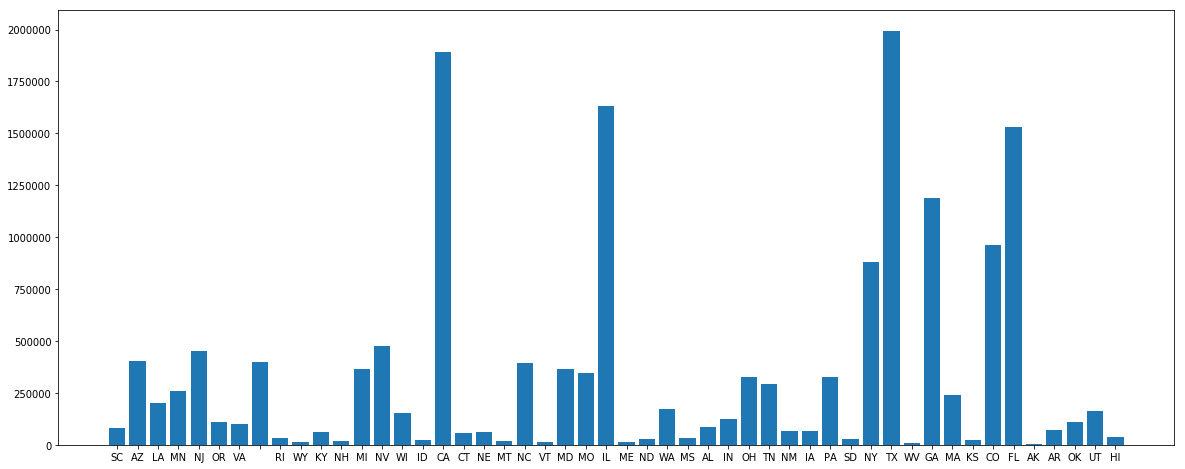

In [67]:
plt.figure(figsize=(20,8))
plt.bar(states_delays_pd['State'], states_delays_pd['Delays'])

# 3 - Prepare Data for Modeling

## Duplicates

In [68]:
df = spark.createDataFrame([
 (1, 144.5, 5.9, 33, 'M'),
 (2, 167.2, 5.4, 45, 'M'),
 (3, 124.1, 5.2, 23, 'F'),
 (4, 144.5, 5.9, 33, 'M'),
 (5, 133.2, 5.7, 54, 'F'),
 (3, 124.1, 5.2, 23, 'F'),
 (5, 129.2, 5.3, 42, 'M'),
 ], schema= ['id', 'weight', 'height', 'age', 'gender'])

In [69]:
df.show()

+---+------+------+---+------+
| id|weight|height|age|gender|
+---+------+------+---+------+
|  1| 144.5|   5.9| 33|     M|
|  2| 167.2|   5.4| 45|     M|
|  3| 124.1|   5.2| 23|     F|
|  4| 144.5|   5.9| 33|     M|
|  5| 133.2|   5.7| 54|     F|
|  3| 124.1|   5.2| 23|     F|
|  5| 129.2|   5.3| 42|     M|
+---+------+------+---+------+



Check pure duplicates:

In [70]:
print('Count of rows: {0}'.format(df.count()))
print('Count of distinct rows: {0}'.format(df.distinct().count()))

Count of rows: 7
Count of distinct rows: 6


In [71]:
df = df.dropDuplicates()

In [72]:
df.show()

+---+------+------+---+------+
| id|weight|height|age|gender|
+---+------+------+---+------+
|  5| 133.2|   5.7| 54|     F|
|  5| 129.2|   5.3| 42|     M|
|  1| 144.5|   5.9| 33|     M|
|  4| 144.5|   5.9| 33|     M|
|  2| 167.2|   5.4| 45|     M|
|  3| 124.1|   5.2| 23|     F|
+---+------+------+---+------+



Check duplicates (other than ID):

In [73]:
print('Counts of IDs: {0}'.format(df.count()))
print('Counts of distinct IDs: {0}'.format(
    df.select([
        c for c in df.columns if c != 'id'
    ]).distinct().count()
))

Counts of IDs: 6
Counts of distinct IDs: 5


In [74]:
df = df.dropDuplicates(
    subset= [c for c in df.columns if c != 'id']
)

In [75]:
df.show()

+---+------+------+---+------+
| id|weight|height|age|gender|
+---+------+------+---+------+
|  5| 133.2|   5.7| 54|     F|
|  1| 144.5|   5.9| 33|     M|
|  2| 167.2|   5.4| 45|     M|
|  3| 124.1|   5.2| 23|     F|
|  5| 129.2|   5.3| 42|     M|
+---+------+------+---+------+



Duplicated IDs:

In [76]:
import pyspark.sql.functions as fn

In [77]:
df.agg(
    fn.count('id').alias('count'),
    fn.countDistinct('id').alias('distinct')
).show()

+-----+--------+
|count|distinct|
+-----+--------+
|    5|       4|
+-----+--------+



Since we have
already dropped all the duplicates, we can safely assume that this might just be a
fluke in our ID data, so we will give each row a unique ID:

In [78]:
df.withColumn('new_id', 
              fn.monotonically_increasing_id()).show()

+---+------+------+---+------+-------------+
| id|weight|height|age|gender|       new_id|
+---+------+------+---+------+-------------+
|  5| 133.2|   5.7| 54|     F|  25769803776|
|  1| 144.5|   5.9| 33|     M| 171798691840|
|  2| 167.2|   5.4| 45|     M| 592705486848|
|  3| 124.1|   5.2| 23|     F|1236950581248|
|  5| 129.2|   5.3| 42|     M|1365799600128|
+---+------+------+---+------+-------------+



In [79]:
df = df.withColumn('id', 
              fn.monotonically_increasing_id())

## Missing observations

- If your data is a discrete Boolean, you can turn it into a categorical variable by adding a third category — Missing
- If your data is already categorical, you can simply extend the number of levels and add the Missing category as well
- If you're dealing with ordinal or numerical data, you can impute either mean, median, or some other predefined value (for example, first or third quartile, depending on the distribution shape of your data)

In [80]:
df_miss = spark.createDataFrame([
 (1, 143.5, 5.6, 28, 'M', 100000),
 (2, 167.2, 5.4, 45, 'M', None),
 (3, None , 5.2, None, None, None),
 (4, 144.5, 5.9, 33, 'M', None),
 (5, 133.2, 5.7, 54, 'F', None),
 (6, 124.1, 5.2, None, 'F', None),
 (7, 129.2, 5.3, 42, 'M', 76000),
 ], ['id', 'weight', 'height', 'age', 'gender', 'income'])

In [82]:
df_miss.show()

+---+------+------+----+------+------+
| id|weight|height| age|gender|income|
+---+------+------+----+------+------+
|  1| 143.5|   5.6|  28|     M|100000|
|  2| 167.2|   5.4|  45|     M|  null|
|  3|  null|   5.2|null|  null|  null|
|  4| 144.5|   5.9|  33|     M|  null|
|  5| 133.2|   5.7|  54|     F|  null|
|  6| 124.1|   5.2|null|     F|  null|
|  7| 129.2|   5.3|  42|     M| 76000|
+---+------+------+----+------+------+



Find the frequency of missing values by column:

In [83]:
df_miss.agg(*[
    (1 - (fn.count(c)/fn.count('*'))).alias(c + '_missing')
    for c in df_miss.columns
]).show()

+----------+------------------+--------------+------------------+------------------+------------------+
|id_missing|    weight_missing|height_missing|       age_missing|    gender_missing|    income_missing|
+----------+------------------+--------------+------------------+------------------+------------------+
|       0.0|0.1428571428571429|           0.0|0.2857142857142857|0.1428571428571429|0.7142857142857143|
+----------+------------------+--------------+------------------+------------------+------------------+



Remove columns with more than 50% of missing values:

In [84]:
df_miss_no_income = df_miss.select([
    c for c in df_miss.columns if c != 'income' 
])

In [85]:
df_miss_no_income.show()

+---+------+------+----+------+
| id|weight|height| age|gender|
+---+------+------+----+------+
|  1| 143.5|   5.6|  28|     M|
|  2| 167.2|   5.4|  45|     M|
|  3|  null|   5.2|null|  null|
|  4| 144.5|   5.9|  33|     M|
|  5| 133.2|   5.7|  54|     F|
|  6| 124.1|   5.2|null|     F|
|  7| 129.2|   5.3|  42|     M|
+---+------+------+----+------+



Find the frequency of missing values by row:

In [86]:
df_miss_no_income.rdd.map(
    lambda row: (row.id, sum([c == None for c in row])/len(row))
).collect()

[(1, 0.0), (2, 0.0), (3, 0.6), (4, 0.0), (5, 0.0), (6, 0.2), (7, 0.0)]

Option 1) Drop rows that has more than 50% of missing values:

In [87]:
df_miss_no_income.rdd.filter(
    lambda row: (sum([c == None for c in row])/len(row) < 0.5) 
).toDF().show()

+---+------+------+----+------+
| id|weight|height| age|gender|
+---+------+------+----+------+
|  1| 143.5|   5.6|  28|     M|
|  2| 167.2|   5.4|  45|     M|
|  4| 144.5|   5.9|  33|     M|
|  5| 133.2|   5.7|  54|     F|
|  6| 124.1|   5.2|null|     F|
|  7| 129.2|   5.3|  42|     M|
+---+------+------+----+------+



Option 2) Impute observations:

In [88]:
means = df_miss_no_income.agg(*[
    fn.mean(c).alias(c)
    for c in df_miss_no_income.columns if c != 'gender'
]).toPandas().to_dict('records')[0]

In [89]:
means

{'id': 4.0,
 'weight': 140.28333333333333,
 'height': 5.471428571428571,
 'age': 40.4}

In [90]:
means['gender'] = 'missing'

In [91]:
df_miss_no_income.fillna(means).show()

+---+------------------+------+---+-------+
| id|            weight|height|age| gender|
+---+------------------+------+---+-------+
|  1|             143.5|   5.6| 28|      M|
|  2|             167.2|   5.4| 45|      M|
|  3|140.28333333333333|   5.2| 40|missing|
|  4|             144.5|   5.9| 33|      M|
|  5|             133.2|   5.7| 54|      F|
|  6|             124.1|   5.2| 40|      F|
|  7|             129.2|   5.3| 42|      M|
+---+------------------+------+---+-------+



## Outliers

Outliers are those observations that deviate significantly from the distribution of
the rest of your sample.

The definitions of significance vary, but in the most general
form, you can accept that there are no outliers if all the values are roughly within
the <b>Q1−1.5IQR</b> and <b>Q3+1.5IQR</b> range, where IQR is the interquartile range; the IQR
is defined as a difference between the upper- and lower-quartiles, that is, the 75th
percentile (the Q3) and 25th percentile (the Q1), respectively.

In [148]:
df_outliers = spark.createDataFrame([
 (1, 143.5, 5.3, 28),
 (2, 154.2, 5.5, 45),
 (3, 342.3, 5.1, 99),
 (4, 144.5, 5.5, 33),
 (5, 133.2, 5.4, 54),
 (6, 124.1, 5.1, 21),
 (7, 129.2, 5.3, 42),
 ], ['id', 'weight', 'height', 'age'])

In [149]:
cols = ['weight', 'height', 'age']
bounds = {}

In [150]:
for col in cols:
    quantiles = df_outliers.approxQuantile(
        col= col, probabilities = [0.25, 0.74],
        relativeError = 0.05)
    IQR = quantiles[1] - quantiles[0]
    bounds[col] = [
        quantiles[0] - 1.5 * IQR,
        quantiles[1] + 1.5 * IQR
    ]

In [151]:
bounds

{'weight': [91.69999999999999, 191.7],
 'height': [4.499999999999999, 6.1000000000000005],
 'age': [-11.0, 93.0]}

Flag outliers:

In [152]:
df_outliers.show()

+---+------+------+---+
| id|weight|height|age|
+---+------+------+---+
|  1| 143.5|   5.3| 28|
|  2| 154.2|   5.5| 45|
|  3| 342.3|   5.1| 99|
|  4| 144.5|   5.5| 33|
|  5| 133.2|   5.4| 54|
|  6| 124.1|   5.1| 21|
|  7| 129.2|   5.3| 42|
+---+------+------+---+



In [153]:
outliers = df_outliers.select(*['id'] + [
 (
 (df_outliers[c] < bounds[c][0]) |
 (df_outliers[c] > bounds[c][1])
 ).alias(c + '_o') for c in cols
])
outliers.show()

+---+--------+--------+-----+
| id|weight_o|height_o|age_o|
+---+--------+--------+-----+
|  1|   false|   false|false|
|  2|   false|   false|false|
|  3|    true|   false| true|
|  4|   false|   false|false|
|  5|   false|   false|false|
|  6|   false|   false|false|
|  7|   false|   false|false|
+---+--------+--------+-----+



Removing outliers:

In [155]:
df_outliers = df_outliers.join(outliers, on='id')

In [157]:
df_outliers = df_outliers.filter(
    df_outliers['weight_o'] == False
).filter(
    df_outliers['height_o'] == False
).filter(
    df_outliers['age_o'] == False
).select(*['id'] + cols)

In [158]:
df_outliers.show()

+---+------+------+---+
| id|weight|height|age|
+---+------+------+---+
|  7| 129.2|   5.3| 42|
|  6| 124.1|   5.1| 21|
|  5| 133.2|   5.4| 54|
|  1| 143.5|   5.3| 28|
|  2| 154.2|   5.5| 45|
|  4| 144.5|   5.5| 33|
+---+------+------+---+



## Getting familiar with data

In [161]:
path_fraud = './data/ccFraud.csv'

In [165]:
df_ccfraud = spark.read.csv(path= path_fraud,
                           inferSchema = True,
                           sep = ',',
                           header = True)

In [166]:
df_ccfraud.show(5)

+------+------+-----+----------+-------+--------+------------+----------+---------+
|custID|gender|state|cardholder|balance|numTrans|numIntlTrans|creditLine|fraudRisk|
+------+------+-----+----------+-------+--------+------------+----------+---------+
|     1|     1|   35|         1|   3000|       4|          14|         2|        0|
|     2|     2|    2|         1|      0|       9|           0|        18|        0|
|     3|     2|    2|         1|      0|      27|           9|        16|        0|
|     4|     1|   15|         1|      0|      12|           0|         5|        0|
|     5|     1|   46|         1|      0|      11|          16|         7|        0|
+------+------+-----+----------+-------+--------+------------+----------+---------+
only showing top 5 rows



Descriptive analysis:

In [168]:
import pyspark.sql.types as typ